In [1]:
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import csv
from shapely.geometry import Point, Polygon

In [2]:
cta_lines = (
    ('Blue Line', 'Q2534873'),
    ('Red Line', 'Q642623'),
    ('Green Line', 'Q3176204'),
    ('Brown Line', 'Q3112936'),
    ('Purple Line', 'Q3112074'),
    ('Pink Line', 'Q3112661'),
    ('Orange Line', 'Q3180068'),
    ('Yellow Line', 'Q595450')
)

In [3]:
wikidata_endpoint = 'https://query.wikidata.org/sparql'

In [4]:
def do_query(query):
    rsp = requests.post(
        wikidata_endpoint,
        data=query,
        headers={
            'Content-type': 'application/sparql-query',
            'Accept': 'application/sparql-results+json',
            'User-Agent': 'https://github.com/avdews/sw-dev-project'
        }
    )
    if rsp.status_code != 200:
        raise Exception(f"Query failed with status code {rsp.status_code}.")
    return rsp.json()

In [11]:
def chicago_L_map():
    cta_stops = []
    for cat, qid in cta_lines:
        query = '''
            SELECT ?station ?stationLabel ?coords WHERE {
              ?station wdt:P31/wdt:P279* wd:Q928830 ;
                wdt:P81 wd:%s ;
                wdt:P625 ?coords . #%s
                SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
            }
        ''' % (qid, cat)
        results = do_query(query)
        dic_keys = results.keys()
        stations = results['results']['bindings']

        length = len(stations)
   
        for i in range(length):
            coord = stations[i]['coords']['value']
            coord = coord[:-1]
            coord = coord[6:]
            coordinates = coord.split()
            
            station = {'name': stations[i]['stationLabel']['value'] + " - " + cat, 'line': cat, 'longitude': coordinates[0], 'latitude': coordinates[1]}
            if station['name'] == 'Airport - Orange Line':
                continue
            cta_stops.append(station)
            
        csv_columns = ['name', 'line', 'longitude', 'latitude']
        csv_file = 'cta_stations.csv'
        
    try:
        with open(csv_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames = csv_columns)
            writer.writeheader()
            for station in cta_stops:
                    writer.writerow(station)
    except IOError:
        print("I/O error")
            
    chicago_map = gpd.read_file(f'./Boundaries - Community Areas (current)/geo_export_4abe0727-ffb5-4896-aac5-d5b76460cabe.shp')
        
    df = pd.read_csv(f'./cta_stations.csv')
    df.crs = "EPSG:4326"
    df.head()
    
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    geometry[:3]
    
    geo_df = gpd.GeoDataFrame(df, crs = df.crs, geometry = geometry )
    geo_df.head()
    
    print('\nChicago "L" Map')
    fig,ax = plt.subplots(figsize = (15,15))
    chicago_map.plot(ax = ax, alpha = 1.0, color = 'darkgrey')
    geo_df[geo_df['line'] == 'Blue Line'].plot(ax = ax, markersize = 20, color = 'blue', marker = "o", label = "Blue Line station")
    geo_df[geo_df['line'] == 'Red Line'].plot(ax = ax, markersize = 20, color = 'red', marker = "o", label = "Red Line station")
    geo_df[geo_df['line'] == 'Green Line'].plot(ax = ax, markersize = 20, color = 'green', marker = "o", label = "Green Line station")
    geo_df[geo_df['line'] == 'Brown Line'].plot(ax = ax, markersize = 20, color = 'brown', marker = "o", label = "Brown Line station")
    geo_df[geo_df['line'] == 'Purple Line'].plot(ax = ax, markersize = 20, color = 'purple', marker = "o", label = "Purple Line station")
    geo_df[geo_df['line'] == 'Orange Line'].plot(ax = ax, markersize = 20, color = 'orange', marker = "o", label = "Orange Line station")
    geo_df[geo_df['line'] == 'Pink Line'].plot(ax = ax, markersize = 20, color = 'brown', marker = "o", label = "Pink Line station")
    geo_df[geo_df['line'] == 'Yellow Line'].plot(ax = ax, markersize = 20, color = 'yellow', marker = "o", label = "Yellow Line station")
    plt.legend(prop = {'size': 15})
    plt.xlabel('Longitude'), plt.ylabel('Latitude')
    


Chicago "L" Map


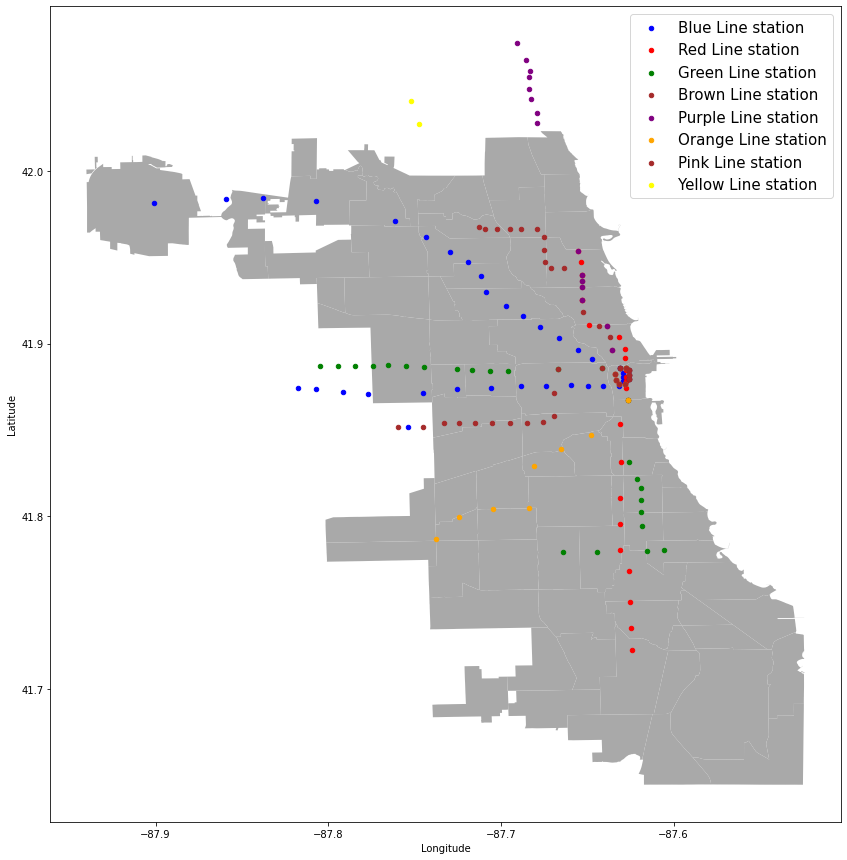

In [12]:
chicago_L_map()